In [143]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import urlopen
from bs4 import BeautifulSoup
%matplotlib inline

plt.style.use('fivethirtyeight')

In [66]:
html = urlopen("http://craftcans.com/db.php?search=all&sort=beerid&ord=desc&view=text")
html_soup = BeautifulSoup(html, 'html.parser')

In [67]:
rows = html_soup.findAll('tr')

In [68]:
print len(rows)

2439


In [124]:
beers = []
for row in rows:
    row.encode('utf-8')
    entries = row.findAll('td')
    if len(entries) == 8:
        id = entries[0].text
        id = id[0:len(id)-1]
        try:
            beer_entry = {
                "id": int(id),
                "name": entries[1].text,
                "brewery_name": entries[2].text,
                "brewery_location": entries[3].text,
                "style": entries[4].text,
                "size": entries[5].text,
                "abv": entries[6].text,    
                "ibu": entries[7].text
            }
            beers.append(beer_entry)
        except ValueError:
            print 'ruh-roh'

ruh-roh


In [125]:
craft_cans = pd.DataFrame(data=beers)
craft_cans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 8 columns):
abv                 2424 non-null object
brewery_location    2424 non-null object
brewery_name        2424 non-null object
ibu                 2424 non-null object
id                  2424 non-null int64
name                2424 non-null object
size                2424 non-null object
style               2424 non-null object
dtypes: int64(1), object(7)
memory usage: 151.6+ KB


In [126]:
craft_cans.describe(include='all')

,abv,brewery_location,brewery_name,ibu,id,name,size,style
count,2424,2424,2424,2424,2424.000000,2424,2424,2424
unique,75,404,554,108,NaN,2318,19,100
top,5.0%,"Grand Rapids, MI",Brewery Vivant,N/A,NaN,Nonstop Hef Hop,12 oz.,American IPA
freq,221,66,62,1010,NaN,12,1482,426
mean,NaN,NaN,NaN,NaN,1438.483498,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,756.488496,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,813.750000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1460.500000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2086.250000,NaN,NaN,NaN


In [133]:
dropnas = craft_cans.replace('N/A',np.nan).dropna().copy()
dropnas.ibu = dropnas.ibu.map(float)
style_means = dict(dropnas.groupby('style').ibu.mean())

ibus = []
for i, ibu in enumerate(craft_cans.ibu):
    if ibu == 'N/A':
        try:
            ibus.append(float(style_means[craft_cans['style'].iloc[i]]))
        except KeyError:
            ibus.append(0.)
    else:
        ibus.append(float(ibu))
craft_cans['ibu_clean'] = ibus

In [134]:
craft_cans.abv.value_counts()

5.0%     221
5.5%     159
6.0%     125
6.5%     125
5.2%     107
7.0%      92
4.5%      89
4.8%      72
5.8%      67
5.6%      66
5.1%      62
6.2%      60
5.3%      60
4.9%      59
8.0%      58
4.7%      57
5.7%      53
6.8%      52
5.4%      50
7.5%      43
6.3%      38
4.0%      38
4.2%      38
7.2%      37
9.9%      35
5.9%      34
4.6%      32
6.9%      31
8.5%      26
6.7%      25
        ... 
9.5%       9
4.1%       9
7.4%       9
8.3%       8
7.9%       7
3.5%       6
3.8%       6
8.8%       6
9.3%       5
9.6%       5
9.7%       5
7.6%       5
8.6%       4
8.1%       4
3.7%       4
9.1%       3
3.2%       3
9.8%       3
8.4%       3
8.9%       2
2.7%       2
10.4%      1
9.4%       1
10.0%      1
12.8%      1
3.4%       1
0.1%       1
12.5%      1
2.8%       1
12.0%      1
Name: abv, Length: 74, dtype: int64

In [135]:
craft_cans = craft_cans[(craft_cans.abv != '???')].copy()

In [136]:
abv_float = [float(x.replace('%','')) for x in craft_cans.abv]
craft_cans['abv_clean'] = abv_float

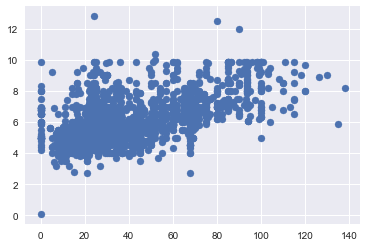

In [142]:
plt.scatter(x=craft_cans.ibu_clean, y=craft_cans.abv_clean);

In [137]:
craft_cans.dtypes

abv                  object
brewery_location     object
brewery_name         object
ibu                  object
id                    int64
name                 object
size                 object
style                object
ibu_clean           float64
abv_clean           float64
dtype: object

In [82]:
q = "query {\n beersByBrewer(brewerId: " + str(100) + ", first: 1000) {\n items {\n id\n name\n styleScore\n averageRating\n ratingCount\n overallScore\n style {\n id\n name\n parent {\n id\n name\n}\n}\n}\n}\n}"
data = {"query":q}

In [83]:
header = {'x-api-key':'8BhI6I8moq7tBc75pyNeb63FgcT3sHlI8CiMaIHF'}
r = requests.post('https://api.r8.beer/v1/api/graphql', data=data, headers=header)

In [84]:
r.status_code

200

In [85]:
response = r.json()

In [86]:
print response

{u'data': {u'beersByBrewer': {u'items': [{u'style': {u'id': u'3', u'parent': {u'id': u'70', u'name': u'Lagers'}, u'name': u'Pale Lager'}, u'name': u'Iron City Beer', u'styleScore': 22.831449930759916, u'overallScore': 1.4709289228027613, u'ratingCount': 541, u'id': u'616', u'averageRating': 1.8351470232009888}, {u'style': {u'id': u'3', u'parent': {u'id': u'70', u'name': u'Lagers'}, u'name': u'Pale Lager'}, u'name': u'Iron City Light', u'styleScore': 8.329007423775067, u'overallScore': 0.5884757425246581, u'ratingCount': 241, u'id': u'7715', u'averageRating': 1.6565979719161987}, {u'style': {u'id': u'3', u'parent': {u'id': u'70', u'name': u'Lagers'}, u'name': u'Pale Lager'}, u'name': u'Pittsburgh Augustiner Lager', u'styleScore': 88.05583865627241, u'overallScore': 10.050642984149455, u'ratingCount': 69, u'id': u'7629', u'averageRating': 2.4854719638824463}, {u'style': {u'id': u'3', u'parent': {u'id': u'70', u'name': u'Lagers'}, u'name': u'Pale Lager'}, u'name': u'Stoneys Beer', u'style

In [81]:
for beer in response['data']['beersByBrewer']['items']:
    print 'Name: ', beer['name'], ' | Style: ', beer['style']['name']

Name:  Iron City Beer  | Style:  Pale Lager
Name:  Iron City Light  | Style:  Pale Lager
Name:  Pittsburgh Augustiner Lager  | Style:  Pale Lager
Name:  Stoneys Beer  | Style:  Pale Lager
Name:  American Beer  | Style:  Pale Lager
Name:  Old German Premium Lager  | Style:  Pale Lager
Name:  Pittsburgh Augustiner Dark  | Style:  Amber Lager/Vienna
Name:  Penns Best NA  | Style:  Low Alcohol
Name:  Iron City Light Mango  | Style:  Fruit Beer
Name:  Falls City Beer  | Style:  Pale Lager
Name:  Block House Double Chocolate Bock  | Style:  Dunkler Bock
Name:  Pittsburgh Sterling  | Style:  Pale Lager
Name:  American Light  | Style:  Pale Lager
Name:  Iron City Amber Classic Lager  | Style:  Amber Lager/Vienna
Name:  Block House Summer Break  | Style:  Fruit Beer
Name:  J.J. Wainwrights Hogs Breath  | Style:  Pale Lager
Name:  Block House Pumpkin Ale  | Style:  Spice/Herb/Vegetable
Name:  Drummond Brothers  | Style:  Pale Lager
Name:  Totally Dirt Cheap Premium Beer  | Style:  Pale Lager
Nam